라이브러리

In [1]:
# imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from tensorflow.keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230715_tank1_nonlinear'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['do_mg', 'feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)

In [9]:
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 2
nCar: 64800 nVar: 1
nCar: 64800 nVar: 2
nCar: 64800 nVar: 1


In [10]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-18]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[18:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-18]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[18:]

In [11]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64782 nVar: 2
nCar: 64782 nVar: 1
nCar: 64782 nVar: 2
nCar: 64782 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [12]:
# Create model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=2))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), epochs=10000000, batch_size=100, verbose=2, callbacks=[es])
model.save(model_name+'.h5')

2023-07-15 06:59:11.149382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 06:59:12.143941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0
/home/jovyan/.venv/tf2.6.0-keras2.6.0-py3.8-cuda11.3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2023-07-15 06:59:12.513173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10000000


2023-07-15 06:59:13.950156: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


648/648 - 6s - loss: 1.1477 - val_loss: 0.1041
Epoch 2/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1039
Epoch 3/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1040
Epoch 4/10000000
648/648 - 4s - loss: 0.1049 - val_loss: 0.1040
Epoch 5/10000000
648/648 - 3s - loss: 0.1049 - val_loss: 0.1114
Epoch 6/10000000
648/648 - 4s - loss: 0.1055 - val_loss: 0.1044
Epoch 7/10000000
648/648 - 4s - loss: 0.1061 - val_loss: 0.1046
Epoch 8/10000000
648/648 - 3s - loss: 0.1060 - val_loss: 0.1071
Epoch 9/10000000
648/648 - 2s - loss: 0.1059 - val_loss: 0.1038
Epoch 10/10000000
648/648 - 3s - loss: 0.1062 - val_loss: 0.1123
Epoch 11/10000000
648/648 - 3s - loss: 0.1064 - val_loss: 0.1035
Epoch 12/10000000
648/648 - 3s - loss: 0.1066 - val_loss: 0.1087
Epoch 13/10000000
648/648 - 3s - loss: 0.1069 - val_loss: 0.1067
Epoch 14/10000000
648/648 - 4s - loss: 0.1061 - val_loss: 0.1040
Epoch 15/10000000
648/648 - 4s - loss: 0.1066 - val_loss: 0.1057
Epoch 16/10000000
648/648 - 4s - loss: 0.1060 - val

648/648 - 2s - loss: 0.1045 - val_loss: 0.1039
Epoch 128/10000000
648/648 - 4s - loss: 0.1048 - val_loss: 0.1070
Epoch 129/10000000
648/648 - 4s - loss: 0.1046 - val_loss: 0.1199
Epoch 130/10000000
648/648 - 4s - loss: 0.1050 - val_loss: 0.1040
Epoch 131/10000000
648/648 - 4s - loss: 0.1048 - val_loss: 0.1044
Epoch 132/10000000
648/648 - 4s - loss: 0.1049 - val_loss: 0.1036
Epoch 133/10000000
648/648 - 4s - loss: 0.1050 - val_loss: 0.1035
Epoch 134/10000000
648/648 - 4s - loss: 0.1046 - val_loss: 0.1046
Epoch 135/10000000
648/648 - 4s - loss: 0.1048 - val_loss: 0.1056
Epoch 136/10000000
648/648 - 4s - loss: 0.1048 - val_loss: 0.1044
Epoch 137/10000000
648/648 - 2s - loss: 0.1047 - val_loss: 0.1040
Epoch 138/10000000
648/648 - 2s - loss: 0.1051 - val_loss: 0.1035
Epoch 139/10000000
648/648 - 3s - loss: 0.1046 - val_loss: 0.1044
Epoch 140/10000000
648/648 - 4s - loss: 0.1051 - val_loss: 0.1038
Epoch 141/10000000
648/648 - 4s - loss: 0.1048 - val_loss: 0.1044
Epoch 142/10000000
648/648 - 

Epoch 252/10000000
648/648 - 4s - loss: 0.1046 - val_loss: 0.1039
Epoch 253/10000000
648/648 - 3s - loss: 0.1043 - val_loss: 0.1070
Epoch 254/10000000
648/648 - 3s - loss: 0.1044 - val_loss: 0.1035
Epoch 255/10000000
648/648 - 4s - loss: 0.1047 - val_loss: 0.1036
Epoch 256/10000000
648/648 - 3s - loss: 0.1042 - val_loss: 0.1051
Epoch 257/10000000
648/648 - 2s - loss: 0.1043 - val_loss: 0.1062
Epoch 258/10000000
648/648 - 2s - loss: 0.1044 - val_loss: 0.1040
Epoch 259/10000000
648/648 - 2s - loss: 0.1044 - val_loss: 0.1059
Epoch 260/10000000
648/648 - 3s - loss: 0.1041 - val_loss: 0.1092
Epoch 261/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1038
Epoch 262/10000000
648/648 - 5s - loss: 0.1046 - val_loss: 0.1038
Epoch 263/10000000
648/648 - 4s - loss: 0.1044 - val_loss: 0.1066
Epoch 264/10000000
648/648 - 4s - loss: 0.1045 - val_loss: 0.1046
Epoch 265/10000000
648/648 - 4s - loss: 0.1043 - val_loss: 0.1036
Epoch 266/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1046
Epoch 267/

648/648 - 2s - loss: 0.1043 - val_loss: 0.1038
Epoch 377/10000000
648/648 - 2s - loss: 0.1041 - val_loss: 0.1035
Epoch 378/10000000
648/648 - 3s - loss: 0.1042 - val_loss: 0.1057
Epoch 379/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1035
Epoch 380/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1035
Epoch 381/10000000
648/648 - 4s - loss: 0.1043 - val_loss: 0.1035
Epoch 382/10000000
648/648 - 4s - loss: 0.1043 - val_loss: 0.1036
Epoch 383/10000000
648/648 - 5s - loss: 0.1042 - val_loss: 0.1035
Epoch 384/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1036
Epoch 385/10000000
648/648 - 5s - loss: 0.1044 - val_loss: 0.1036
Epoch 386/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1035
Epoch 387/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1041
Epoch 388/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1053
Epoch 389/10000000
648/648 - 3s - loss: 0.1042 - val_loss: 0.1036
Epoch 390/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1044
Epoch 391/10000000
648/648 - 

Epoch 501/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 502/10000000
648/648 - 5s - loss: 0.1042 - val_loss: 0.1035
Epoch 503/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1045
Epoch 504/10000000
648/648 - 3s - loss: 0.1041 - val_loss: 0.1036
Epoch 505/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1036
Epoch 506/10000000
648/648 - 3s - loss: 0.1041 - val_loss: 0.1037
Epoch 507/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1048
Epoch 508/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1036
Epoch 509/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1035
Epoch 510/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1095
Epoch 511/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1035
Epoch 512/10000000
648/648 - 5s - loss: 0.1040 - val_loss: 0.1036
Epoch 513/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 514/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1047
Epoch 515/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1067
Epoch 516/

648/648 - 4s - loss: 0.1041 - val_loss: 0.1041
Epoch 626/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 627/10000000
648/648 - 4s - loss: 0.1042 - val_loss: 0.1035
Epoch 628/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1036
Epoch 629/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1063
Epoch 630/10000000
648/648 - 2s - loss: 0.1043 - val_loss: 0.1036
Epoch 631/10000000
648/648 - 2s - loss: 0.1039 - val_loss: 0.1038
Epoch 632/10000000
648/648 - 2s - loss: 0.1040 - val_loss: 0.1050
Epoch 633/10000000
648/648 - 3s - loss: 0.1039 - val_loss: 0.1043
Epoch 634/10000000
648/648 - 3s - loss: 0.1041 - val_loss: 0.1035
Epoch 635/10000000
648/648 - 2s - loss: 0.1041 - val_loss: 0.1044
Epoch 636/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1077
Epoch 637/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1035
Epoch 638/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1045
Epoch 639/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1037
Epoch 640/10000000
648/648 - 

Epoch 750/10000000
648/648 - 3s - loss: 0.1039 - val_loss: 0.1037
Epoch 751/10000000
648/648 - 3s - loss: 0.1039 - val_loss: 0.1044
Epoch 752/10000000
648/648 - 2s - loss: 0.1039 - val_loss: 0.1039
Epoch 753/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1040
Epoch 754/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1035
Epoch 755/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1035
Epoch 756/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1035
Epoch 757/10000000
648/648 - 5s - loss: 0.1040 - val_loss: 0.1035
Epoch 758/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1035
Epoch 759/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1042
Epoch 760/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 761/10000000
648/648 - 4s - loss: 0.1041 - val_loss: 0.1037
Epoch 762/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 763/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 764/10000000
648/648 - 3s - loss: 0.1038 - val_loss: 0.1035
Epoch 765/

648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 875/10000000
648/648 - 4s - loss: 0.1038 - val_loss: 0.1037
Epoch 876/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1036
Epoch 877/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1036
Epoch 878/10000000
648/648 - 2s - loss: 0.1039 - val_loss: 0.1035
Epoch 879/10000000
648/648 - 2s - loss: 0.1039 - val_loss: 0.1052
Epoch 880/10000000
648/648 - 2s - loss: 0.1039 - val_loss: 0.1038
Epoch 881/10000000
648/648 - 2s - loss: 0.1038 - val_loss: 0.1037
Epoch 882/10000000
648/648 - 3s - loss: 0.1039 - val_loss: 0.1045
Epoch 883/10000000
648/648 - 3s - loss: 0.1038 - val_loss: 0.1039
Epoch 884/10000000
648/648 - 2s - loss: 0.1039 - val_loss: 0.1038
Epoch 885/10000000
648/648 - 2s - loss: 0.1039 - val_loss: 0.1038
Epoch 886/10000000
648/648 - 4s - loss: 0.1038 - val_loss: 0.1035
Epoch 887/10000000
648/648 - 4s - loss: 0.1040 - val_loss: 0.1039
Epoch 888/10000000
648/648 - 4s - loss: 0.1039 - val_loss: 0.1035
Epoch 889/10000000
648/648 - 

모델 평가

In [13]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [14]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-7.45425187e-03  1.18306410e-02 -1.41901299e-01 -2.11314589e-01
  -1.29603833e-01  4.10854956e-03  3.67933139e-03 -4.42923665e-01
   2.65404140e-03 -3.35292995e-01  3.46826583e-01  1.40802155e-03
   9.80758481e-03  1.35873137e-02 -1.36426359e-01  9.59525444e-03
   9.42850206e-03  1.54553377e-03 -2.24032491e-01  2.26039857e-01
   1.02023222e-02  2.29107484e-01 -1.23847909e-01 -1.35210723e-01
  -2.97780335e-03 -7.51497522e-02  2.11441796e-02 -5.74497581e-02
   1.54744033e-02 -1.37316138e-01 -1.48195624e-01  5.05389273e-03
  -1.45482987e-01  2.20751554e-01 -1.65127918e-01 -1.69239745e-01
   2.47274503e-01  2.36151926e-03  1.35312947e-02 -1.18338510e-01
   9.26288962e-03  5.70594706e-03 -1.81120351e-01 -1.58710495e-01
  -1.03920251e-01 -1.98505700e-01 -7.49678910e-03 -1.16235152e-01
   5.93926944e-02  5.21891471e-03  2.49341965e-01 -4.94715571e-02
  -2.14414746e-02  8.05193186e-03 -1.73780590e-01  2.57452647e-03
   1.59924524e-03 -6.75975680e-02 -9.68039557e-02 -6.38233125e-03
  -3.57228

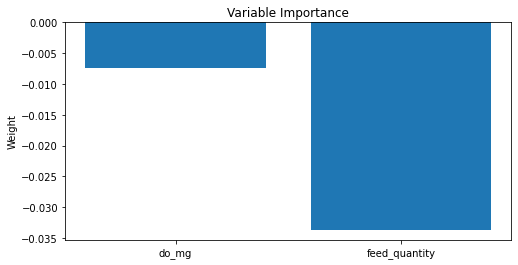

In [15]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [16]:
japonica_validation_features_X

,do_mg,feed_quantity
mea_dt,,
2021-07-21 00:00:00,7.7,0.0
2021-07-21 00:01:00,7.8,0.0
2021-07-21 00:02:00,7.8,0.0
2021-07-21 00:03:00,7.8,0.0
2021-07-21 00:04:00,7.9,0.0
...,...,...
2021-09-08 23:55:00,8.7,0.0
2021-09-08 23:56:00,8.7,0.0
2021-09-08 23:57:00,8.7,0.0


In [17]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 2


In [18]:
y_date = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-09-10 20:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 64800 nVar: 1


64800


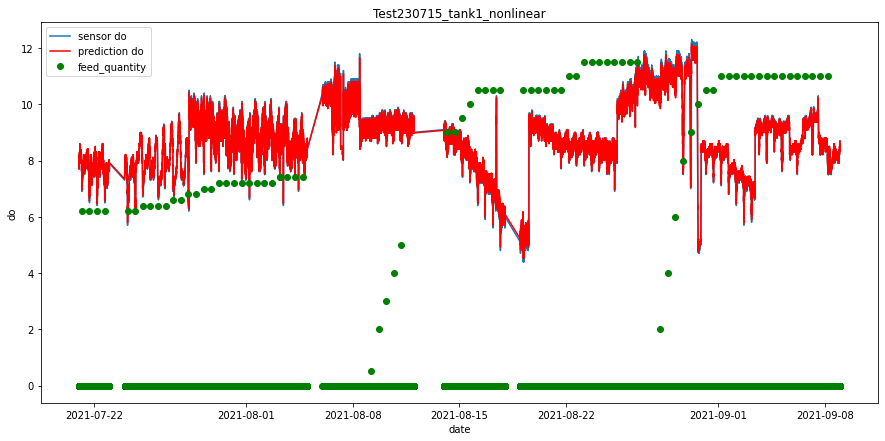

2025/2025 [==============================] - 5s 3ms/step - loss: 0.0023
MSE // MAE // R-squared  0.0023231853265315294


In [19]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [20]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 2


In [21]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 1
nCar: 14220 nVar: 1


14220


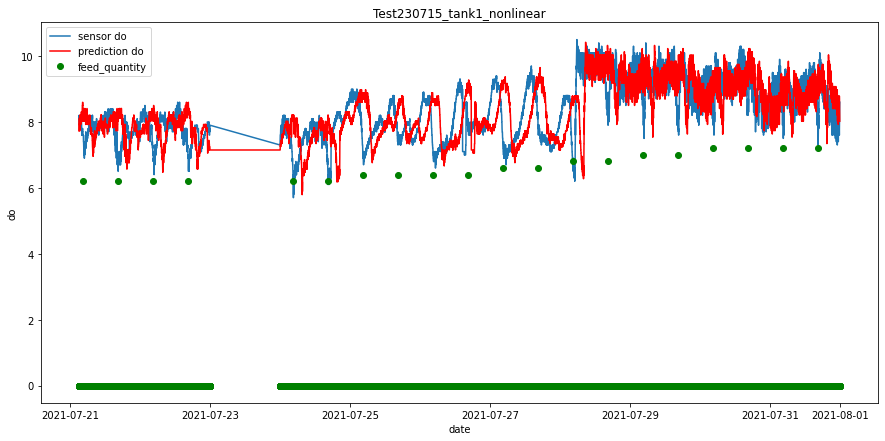

445/445 [==============================] - 2s 3ms/step - loss: 0.6651
MSE // MAE // R-squared  0.6651027202606201


In [22]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [23]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 2


In [24]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 1
nCar: 1260 nVar: 1


1260


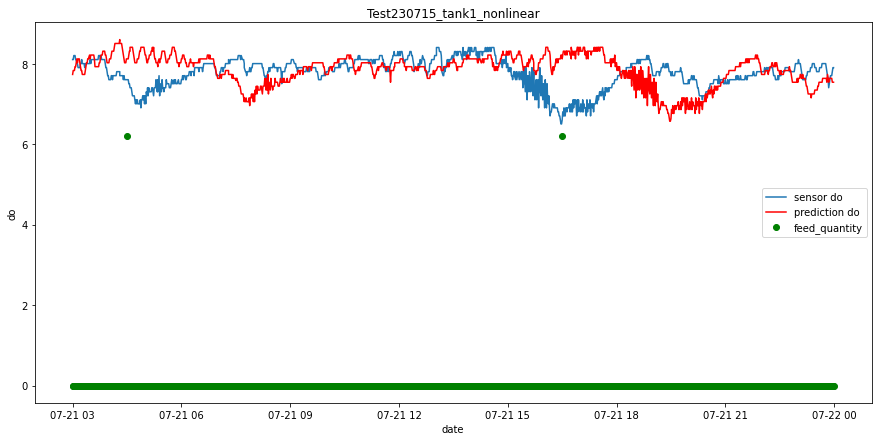

40/40 [==============================] - 0s 4ms/step - loss: 0.3335
MSE // MAE // R-squared  0.3335225582122803


In [25]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [26]:
X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 2


In [27]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


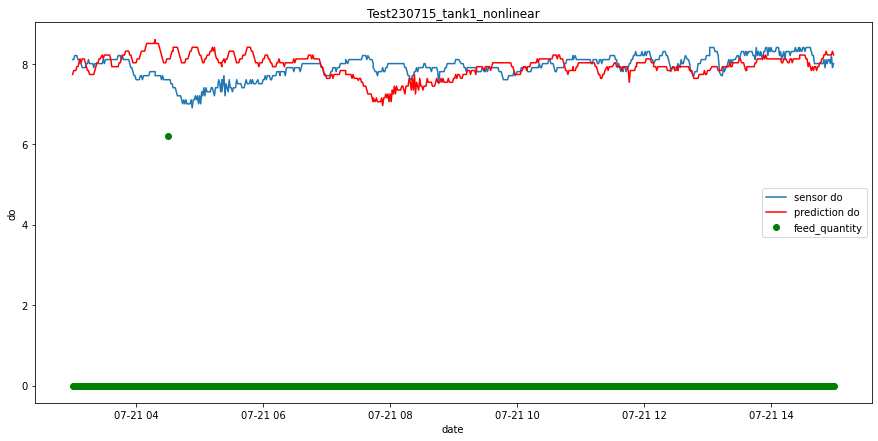

23/23 [==============================] - 0s 3ms/step - loss: 0.1949
MSE // MAE // R-squared  0.1948772817850113


In [28]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [29]:
japonica_validation_features_X.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-21 00:00':'2021-07-21 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [30]:
y_date = japonica_validation_features_X.loc['2021-07-21 03:00':'2021-07-21 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


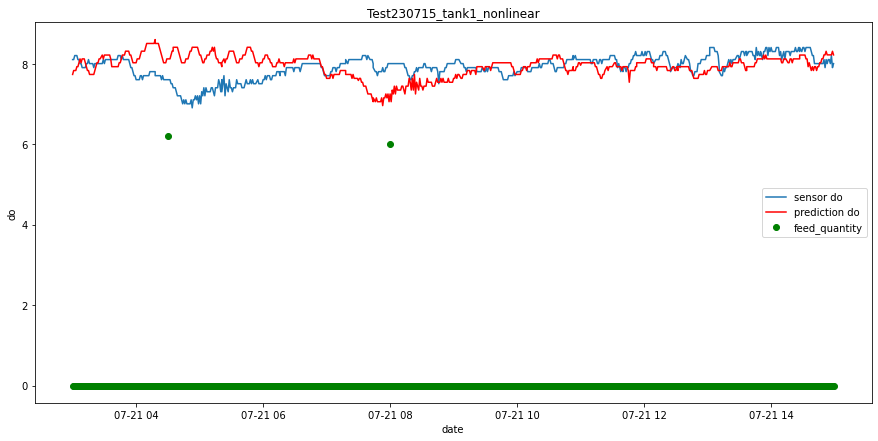

23/23 [==============================] - 0s 3ms/step - loss: 0.1949
MSE // MAE // R-squared  0.1948958933353424


In [31]:
grapeNEva(model,X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)